# Hands-on Tutorial: AI Fundamentals for Research (joint session BP/TUT/DY/AKPIK)
Sunday, 16th March 2025, 16:00–18:15, H2<br>
Presented at the **[2025 DPG Spring Meeting of the Condensed Matter Section](https://www.dpg-verhandlungen.de/year/2025/conference/regensburg/part/tut/session/1)**

## Hands-On Session 2: Classification and More

#### Jan Bürger<sup>1</sup>, Janine Graser<sup>2</sup>, •Robin Msiska<sup>2,3</sup>, and Arash Rahimi-Iman<sup>4</sup>

<sup>1</sup>ErUM-Data-Hub, RWTH Aachen University, Aachen, Germany<br>
<sup>2</sup>Faculty of Physics and Center for Nanointegration Duisburg-Essen (CENIDE), University of Duisburg-Essen, Duisburg, Germany<br>
<sup>3</sup>Department of Solid State Sciences, Ghent University, Ghent, Belgium<br>
<sup>4</sup>I. Physikalisches Institut and Center for Materials Research, Justus-Liebig-University Gießen, Gießen, Germany

### Abstract
*The session demonstrates how pre-trained models can simplify tasks such as classification, making them readily applicable to research. Typical examples include recognizing handwritten digits, which showcase the power of pretrained models in solving common challenges. As a preview of advanced topics, the tutorial concludes with brief examples of large language models (LLMs) and generative AI.*"


### About this notebook
#### **Presenter: Robin Msiska**

In this notebook, we'll explore three fundamental applications of neural networks in image processing:

1. **Image Classification**: Identifying what's in an image (e.g., recognising handwritten digits

2. **Image Denoising**: Cleaning up noisy or corrupted images
3. **Transfer Learning**: Using knowledge from one task to improve performance on another

We'll use the MNIST (Modified National Institute of Standards and Technology) dataset of handwritten digits as our playground. While simple, this dataset allows us to understand core concepts that scale to more complex research-specific tasks.

<img src="img/mnist-digits-classification.png" alt="MNIST" width="800"/>

### Why These Topics Matter

These techniques form the foundation of many real-world AI applications. Here are some ways that they are used in condensed matter physics:

**Classification**
- Detecting anomalies in experimental measurements <br>
e.g. P. Napoletano, F. Piccoli, & R. Schettini, [*Sensors* **18**(1), 209 (2018)](https://www.mdpi.com/1424-8220/18/1/209)<br>
<img src="img/eg_anomaly.png" alt="Paper CNN anomaly" width="400"/>

- Classifying phase transitions in material systems<br>
e.g. K. Kottmann, P. Huembeli, M. Lewenstein, and A. Acín, [*Phys. Rev. Lett.* **125**, 170603 (2020)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.125.170603)<br>
<img src="img/eg_phase.png" alt="Paper CNN phase transition" width="400"/>

**Denoising**
- Enhancing microscopy and imaging data
- Cleaning experimental signals from background noise<br>
e.g. K. Wu et al., [*Anal. Chem.* **93**, 3, 1377–1382 (2021)](https://pubs.acs.org/doi/abs/10.1021/acs.analchem.0c03087)<br>
<img src="img/eg_denoise.png" alt="Paper denoising" width="400"/>

**Transfer Learning**
- Applying models trained on simulated physics data to real experiments
- Adapting solutions between similar physical systems
- Leveraging knowledge between different energy scales<br>
e.g. D. Jha, K. Choudhary, F. Tavazza et al, [*Nat Commun* **10**, 5316 (2019)](https://www.nature.com/articles/s41467-019-13297-w)<br>
<img src="img/eg_transfer.png" alt="Paper transfer learning" width="300"/>

### What You'll Learn

By the end of this notebook, you'll understand:
- How Convolutional Neural Networks (CNNs) work for image classification
- How autoencoders can clean up noisy images
- How to transfer knowledge from one trained neural network to another

In [1]:
import torch

# Set the GPU device
myGPU = 0
device = torch.device(f'cuda:{myGPU}' if torch.cuda.is_available() else 'cpu')

# Set the current device
torch.cuda.set_device(device)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(myGPU)

print(f'Using {device} device')

Using cuda:0 device


In [2]:
# For automatic execution time tracking
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 27.6 μs (started: 2025-03-15 14:20:49 +01:00)


In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml

print('PyTorch version:', torch.__version__)

PyTorch version: 2.6.0+cu124
time: 682 ms (started: 2025-03-15 14:20:49 +01:00)


## Part 1: Image Classification with CNNs

### What is Image Classification?

Image classification is the task of assigning a label to an image from a fixed set of categories.

MNIST is a classic dataset of handwritten digits. It contains:
- 60,000 training images
- 10,000 test images
- Each image is 28×28 pixels in grayscale (0-255 pixel values)
- 10 classes (digits 0-9)

Below we load the MNIST dataset using PyTorch utilities and visualize some examples.

Training set shape: torch.Size([60000, 1, 28, 28])
Test set shape: torch.Size([10000, 1, 28, 28])


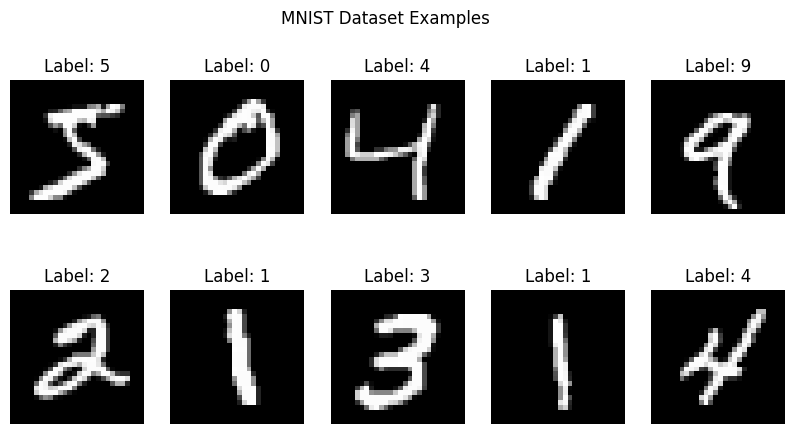

time: 2.7 s (started: 2025-03-15 14:20:49 +01:00)


In [4]:
# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

# Convert the data and labels to NumPy arrays
X = np.array(mnist.data, dtype=np.float32)  # shape: (70000, 784)
y = np.array(mnist.target, dtype=np.int64)    # shape: (70000,)

# Normalize pixel values and reshape to (N, 1, 28, 28)
X = X / 255.0
X = X.reshape(-1, 28, 28)
X = torch.tensor(X).unsqueeze(1)  # add channel dimension

# Split into training and test sets (60,000 for training and 10,000 for testing)
x_train, y_train = X[:60000], torch.tensor(y[:60000])
x_test, y_test = X[60000:], torch.tensor(y[60000:])

print('Training set shape:', x_train.shape)
print('Test set shape:', x_test.shape)

# Visualize 10 examples
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    # squeeze channel dimension for visualization
    plt.imshow(x_train[i].squeeze(0), cmap='gray')
    plt.title(f'Label: {y_train[i].item()}')
    plt.axis('off')
plt.suptitle('MNIST Dataset Examples')
plt.show()

### What are Convolutional Neural Networks (CNNs)?
CNNs are a specialized type of neural network designed to process grid-like data such as images.
#### A Visual Overview of our CNN
<img src="img/CNN.png" alt="CNN" width="700"/>

#### Convolutional layer

This is Made up of:
- **Convolutional Layers** that slide over the image to extract local features.

- **Activation Functions** that introduce non-linearity; for example, ReLU $ f(x) = \max(0, x) $

<img src="img/CNN_cov.png" alt="Convolution operation" width="600"/>

##### Convolutional operation
The convolution operation is at the core of CNNs.  The convolution operation is mathematically described as:

$$ (F * I)_{x,y} = \sum_{i}\sum_{j} F_{i,j} \cdot I_{x+i,y+j} $$

<img src="img/conv_op.png" alt="Convolution operation" width="800"/> ~ B.K. Kalejahi, S. Meshgini, S. Danishvar, S. Khorram, [Intelligent Data Analysis 26(4), 1097-1114 (2022)](https://journals.sagepub.com/doi/full/10.3233/IDA-216379)

The small matrix of weights in the image is called the kernel or filter and it slides across an image, applying the same pattern-detecting weights at each position. This reuse of weights (parameter sharing) helps detect features regardless of their location in the image.

![same_padding_no_strides.gif](img/same_padding_no_strides.gif)
~ animation from D. Vincent, F. Visin. [arXiv:1603.07285 (2016)](https://arxiv.org/abs/1603.07285)
##### DIfferent kernels lead to different image processing results

For instance with kernel 
$\begin{bmatrix}
1/9 & 1/9 & 1/9 \\
1/9 & 1/9 & 1/9 \\
1/9 & 1/9 & 1/9
\end{bmatrix}$ we can blur an image

<img src="img/gaussian_blur_demo_400x400_fixed.gif" alt="Gaussian" width="800"/>

A different kernel
$\begin{bmatrix}
1 & 2 & 1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{bmatrix}$ would yield:

<img src="img/sobel.png" alt="Sobel" width="600"/>

#### Pooling

<img src="img/CNN_maxpool.png" alt="CNN maxpool" width="600"/>

In CNN architectures, it is typical that the spatial dimension of the data is reduced periodically via pooling layers. Pooling layers are typically used after a series of convolutional layers to reduce the spatial size of the activation maps. You can think of this as a way to summarise the features from an activation map. Using a pooling layer will reduce the number of parameters in the network because the input size to subsequent layers is reduced. This is a desirable effect because the computations required for training are also reduced. Also, using fewer parameters often helps to mitigate the effects of overfitting. Here we use **Max pooling**.

<img src="img/MaxPool.png" alt="Max Pooling" width="800"/>

- **Pooling Layers (MaxPooling):** Downsample the image by reducing its spatial dimensions. With a 2×2 window, the pooling operation is:

  $$ \mathrm{MaxPool}(X)_{i,j} = \max(X_{2i,2j}, X_{2i,2j+1}, X_{2i+1,2j}, X_{2i+1,2j+1}) $$

#### Dense Layers
Fully connected layers that combine features to perform classification.

<img src="img/CNN_dense.png" alt="CNN dense" width="600"/>

Softmax is used in the final layer of the network to transform the network's output (which is a vector of raw logits) into probabilities. Softmax takes converts output into a probability distribution by applying the following formula to each element $ z_i $ of the output vector:

  $$ P(y_i) = \frac{e^{z_i}}{\sum_j e^{z_j}} $$

Where:

- $ P(y_i) $ is the probability of class $ i $
- $ z_i $ is the corresponding to class $ i $
- The denominator is the sum over all classes.

The output of Softmax is a vector where each value represents the probability that the input image belongs to a particular class. The class with the highest probability is the predicted label.

#### Summary:

- **Convolutional layers**: Apply sliding filters across the image to detect features like edges, textures, and patterns
- **Pooling layers**: Reduce the spatial dimensions of the data, making the network more computationally efficient and robust to variations
- **Local connectivity**: Each neuron connects to only a small region of the input, unlike fully-connected networks
- **Parameter sharing**: The same weights are applied across the entire image

These properties make CNNs extremely efficient for image processing tasks.

We will now implement a CNN

In [5]:
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, input_shape):
        super(CNNModel, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten the 2D feature maps for the fully connected layers
        # Calculate the size of the flattened features
        self.flatten = nn.Flatten()
        
        # Fully connected (dense) layers
        # Calculate the size of the flattened features after the second pooling layer
        # After two poolings, image size reduces from 28x28 to 7x7
        #self.fc1 = nn.Linear(64 * 7 * 7, 64)
        self.fc1 = nn.Linear(64 * (input_shape[1] // 4) * (input_shape[2] // 4), 64)
        self.fc2 = nn.Linear(64, 10)
    
    def forward(self, x):
        # First convolutional block
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        # Second convolutional block
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        # Flatten the 2D feature maps
        x = self.flatten(x)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        # Apply softmax to the output layer
        x = F.softmax(x, dim=1)
        
        return x

# Example usage
input_shape = (1, 28, 28)  # Example input shape for MNIST dataset (1 channel, 28x28 images)
classification_model = CNNModel(input_shape)

# Print the model architecture
print(classification_model)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
time: 2.48 ms (started: 2025-03-15 14:20:52 +01:00)


### Training Parameters

We will train the classification model using the following settings:

- **Epochs**: 5
- **Batch Size**: 128
- **Validation Split**: 10% of the training data

Below is a training loop using PyTorch that tracks training and validation loss and accuracy

In [6]:
from torch.utils.data import TensorDataset, DataLoader

# Split training set into train and validation subsets (90/10 split)
num_train = len(x_train)
split = int(0.9 * num_train)

train_imgs, val_imgs = x_train[:split], x_train[split:]
train_labels, val_labels = y_train[:split], y_train[split:]

train_ds = TensorDataset(train_imgs, train_labels)
val_ds   = TensorDataset(val_imgs, val_labels)
 
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classification_model = classification_model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classification_model.parameters(), lr=0.001)

num_epochs = 5
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    classification_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = classification_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)
    
    # Validation
    classification_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = classification_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss = val_loss / total_val
    val_acc = correct_val / total_val
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}]: Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch [1/5]: Train Loss: 1.6609, Train Acc: 0.8108, Val Loss: 1.5020, Val Acc: 0.9638
Epoch [2/5]: Train Loss: 1.4967, Train Acc: 0.9671, Val Loss: 1.4858, Val Acc: 0.9768
Epoch [3/5]: Train Loss: 1.4843, Train Acc: 0.9785, Val Loss: 1.4775, Val Acc: 0.9850
Epoch [4/5]: Train Loss: 1.4795, Train Acc: 0.9828, Val Loss: 1.4772, Val Acc: 0.9850
Epoch [5/5]: Train Loss: 1.4770, Train Acc: 0.9851, Val Loss: 1.4747, Val Acc: 0.9880
time: 7.09 s (started: 2025-03-15 14:20:52 +01:00)


#### Visualizing the training history

We visualize the training and validation accuracy and loss over epochs during model training

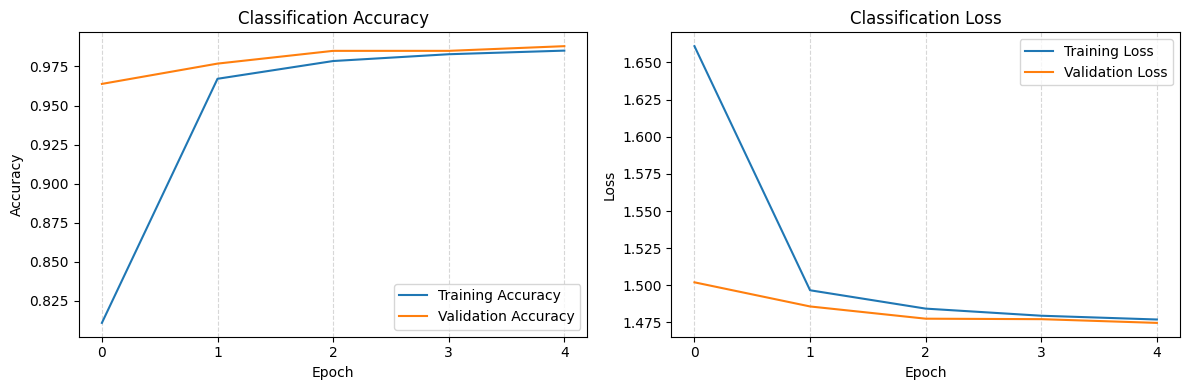

time: 123 ms (started: 2025-03-15 14:20:59 +01:00)


In [7]:
# Visualize training history
plt.figure(figsize=(12, 4))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Loss')
plt.legend()

# Add vertical lines and format x-axis to show only integer epochs
for ax in plt.gcf().axes:  # Loop through all subplots
    ax.set_xticks(np.arange(0, len(train_acc_history), 1))  # Set x-ticks to integer epochs
    ax.grid(axis='x', linestyle='--', alpha=0.5)  # Add faint vertical grid lines

plt.tight_layout()
plt.show()

##### Evaluate model test Set
We now evaluate the trained classification model on the test set, computing the test loss and accuracy

In [8]:
# Evaluate the classification model on the test set
from torch.utils.data import DataLoader

test_ds = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

classification_model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classification_model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss /= total_test
test_acc = correct_test / total_test
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

Test accuracy: 0.9840
Test loss: 1.4779
time: 64.1 ms (started: 2025-03-15 14:20:59 +01:00)


##### Model prediction
We now visualize the predictions of a trained classification model on 8 randomly selected test samples. Output shows the images along with the predicted and actual labels, highlighting any incorrect predictions in red

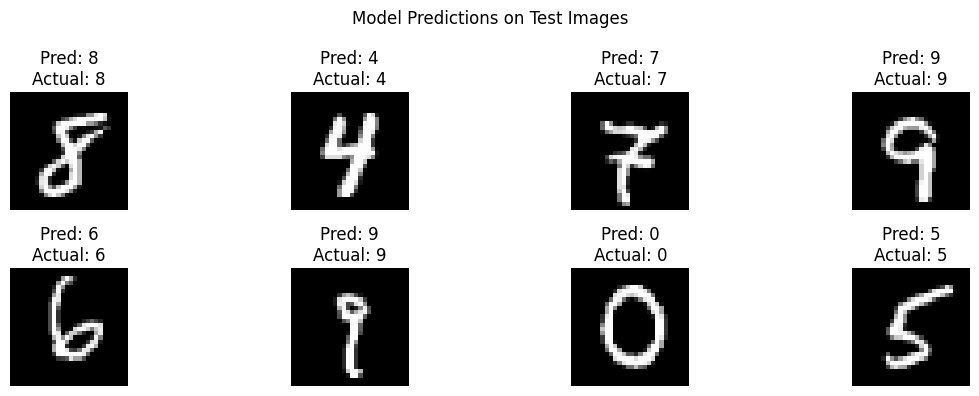

time: 144 ms (started: 2025-03-15 14:20:59 +01:00)


In [9]:
# Visualize model predictions on 8 random test samples
indices = np.random.choice(x_test.shape[0], 8, replace=False)
sample_images = x_test[indices]
sample_labels = y_test[indices]

classification_model.eval()
with torch.no_grad():
    outputs = classification_model(sample_images.to(device))
    preds = torch.argmax(outputs, dim=1).cpu().numpy()

plt.figure(figsize=(12, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(sample_images[i].squeeze(0), cmap='gray')
    title_color = 'black'
    if preds[i] != sample_labels[i].item():
        title_color = 'red'
    plt.title(f'Pred: {preds[i]}\nActual: {sample_labels[i].item()}', color=title_color)
    plt.axis('off')
plt.suptitle('Model Predictions on Test Images')
plt.tight_layout()
plt.show()

#### Confusion matrix

A confusion matrix is a tool used to evaluate the performance of a classification model. It shows the actual vs. predicted classifications in a table format, helping you to understand how well your model is performing. 

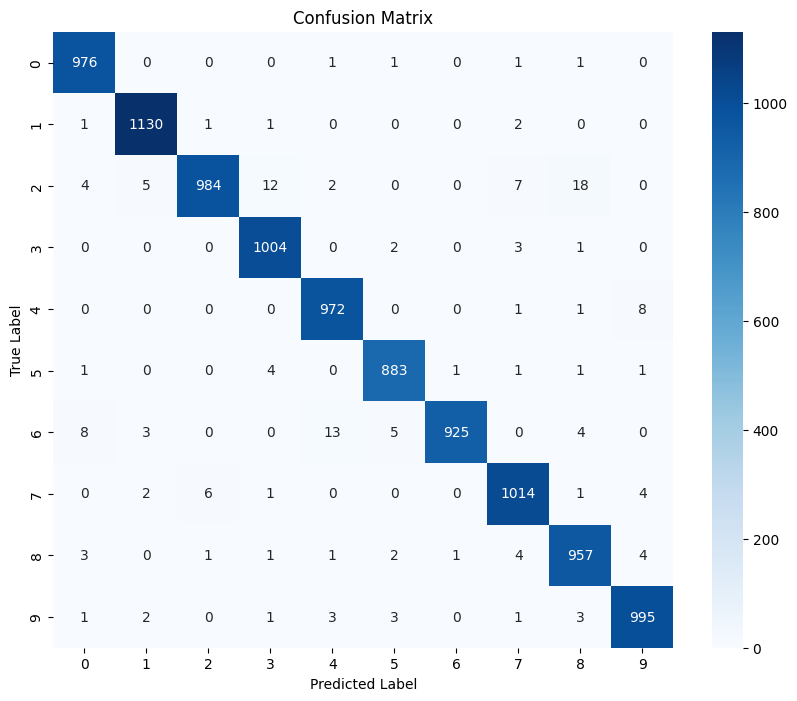

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.95      0.97      1032
           3       0.98      0.99      0.99      1010
           4       0.98      0.99      0.98       982
           5       0.99      0.99      0.99       892
           6       1.00      0.97      0.98       958
           7       0.98      0.99      0.98      1028
           8       0.97      0.98      0.98       974
           9       0.98      0.99      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

time: 249 ms (started: 2025-03-15 14:21:00 +01:00)


In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Obtain predictions on the complete test set
all_preds = []
classification_model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = classification_model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds.tolist())

cm = confusion_matrix(y_test.numpy(), all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print('Classification Report:')
print(classification_report(y_test.numpy(), all_preds))

## Part 2: Transfer Learning for Image Segmentation
Image segmentation is the process of partitioning an image into multiple segments or regions, often to simplify or change the representation of an image. The goal is to assign a label to each pixel in the image, indicating whether it belongs to a specific object, background, or region of interest.

<img src="img/dog1.jpg" alt="Autoencorder" width="400"/><img src="img/dog2.png" alt="Autoencorder" width="400"/>

In this section we build an encoder–decoder model (a common architecture for segmentation) in PyTorch.

<img src="img/AE.png" alt="Autoencorder" width="800"/>

Phase 1: We pre-train the model to segment MNIST digits (background=0, digit=1).

Phase 2: We augment the images by adding randomly rotated white hearts and update the masks accordingly (hearts are labeled as 2), then fine-tune the model.

In [11]:
class SegmentationModel(nn.Module):
    def __init__(self, num_classes):
        super(SegmentationModel, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU())
        
        # Decoder
        self.dec1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU())
        self.dec2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU())
        
        # Output layer (for segmentation, we output raw logits)
        self.out_conv = nn.Conv2d(32, num_classes, kernel_size=1)
        
    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.bottleneck(x)
        x = self.dec1(x)
        x = self.dec2(x)
        x = self.out_conv(x)
        return x

# For segmentation, we create masks from the MNIST images
# Pixels > 0.1 are considered part of the digit (class 1); background = 0
y_train_digits = (x_train > 0.1).squeeze(1).long()  # shape: [60000, 28, 28]
y_test_digits  = (x_test > 0.1).squeeze(1).long()


time: 23.3 ms (started: 2025-03-15 14:21:00 +01:00)


##### Pre-train segmentation: Phase 1 (2 classes: background and digit)
We now train a segmentation model (`SegmentationModel`)  to differentiate between the background and digits in an image. This model can later be fine-tuned for more complex tasks


In [12]:
# Use the full training set for segmentation
num_seg = x_train.size(0)
split_seg = int(0.9 * num_seg)

seg_train_imgs = x_train[:split_seg]
seg_train_masks = y_train_digits[:split_seg]
seg_val_imgs   = x_train[split_seg:]
seg_val_masks  = y_train_digits[split_seg:]

from torch.utils.data import DataLoader, TensorDataset
seg_train_ds = TensorDataset(seg_train_imgs, seg_train_masks)
seg_val_ds   = TensorDataset(seg_val_imgs, seg_val_masks)

seg_train_loader = DataLoader(seg_train_ds, batch_size=128, shuffle=True)
seg_val_loader   = DataLoader(seg_val_ds, batch_size=128, shuffle=False)

model_phase1 = SegmentationModel(num_classes=2).to(device)
criterion_seg = nn.CrossEntropyLoss()
optimizer_seg = optim.Adam(model_phase1.parameters(), lr=0.001)

print("Training Phase 1: Segmenting digits (background vs. digit)...")
num_epochs_seg = 5
for epoch in range(num_epochs_seg):
    model_phase1.train()
    running_loss = 0.0
    for imgs, masks in seg_train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer_seg.zero_grad()
        outputs = model_phase1(imgs)  # shape: [B, 2, 28, 28]
        loss = criterion_seg(outputs, masks)
        loss.backward()
        optimizer_seg.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(seg_train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs_seg}] - Loss: {epoch_loss:.4f}")

# Save the pretrained weights for transfer learning
torch.save(model_phase1.state_dict(), 'pretrained_model_phase1.pth')

Training Phase 1: Segmenting digits (background vs. digit)...
Epoch [1/5] - Loss: 0.0755
Epoch [2/5] - Loss: 0.0329
Epoch [3/5] - Loss: 0.0265
Epoch [4/5] - Loss: 0.0231
Epoch [5/5] - Loss: 0.0210
time: 14.8 s (started: 2025-03-15 14:21:00 +01:00)


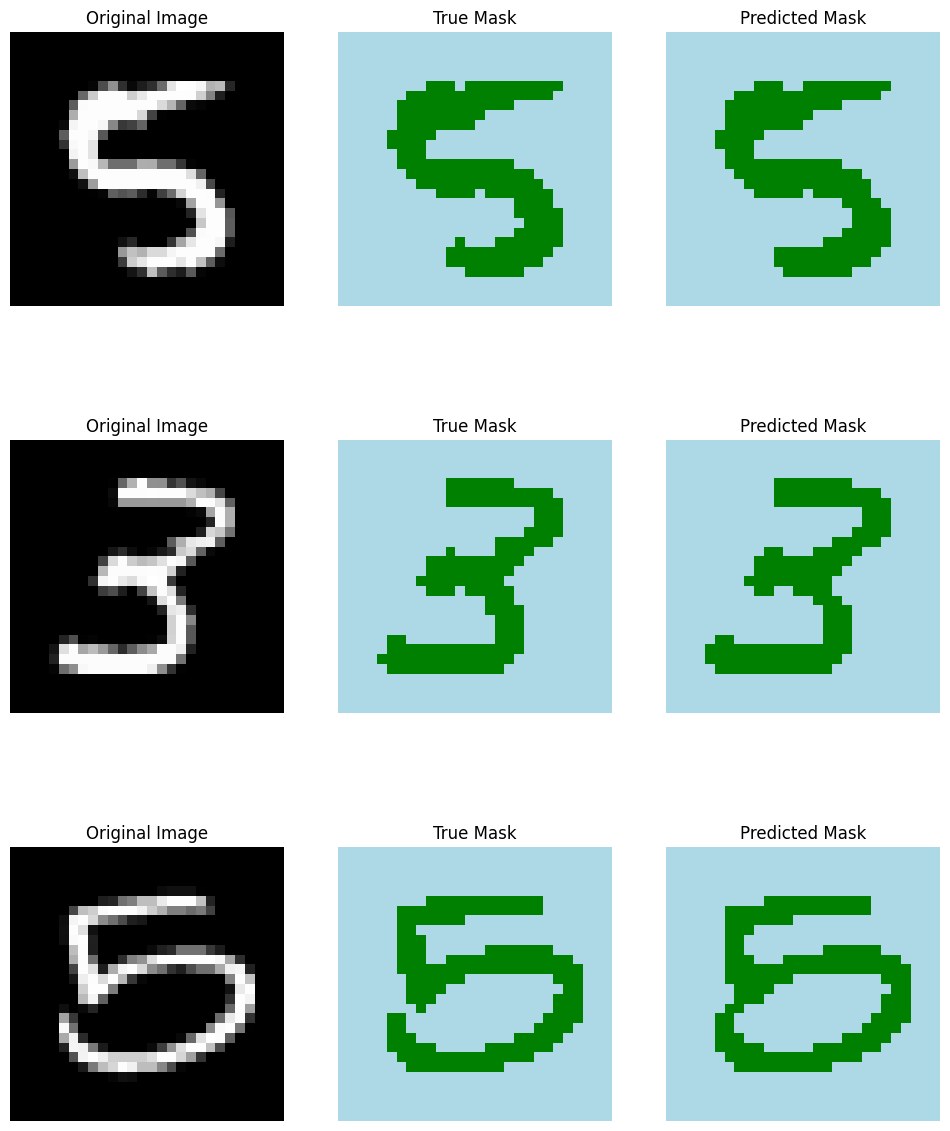

time: 179 ms (started: 2025-03-15 14:21:15 +01:00)


In [13]:
# Define custom colormap: Light Blue for background and Green for digit
custom_cmap = ListedColormap(['lightblue', 'green'])

# Set the model to evaluation mode
model_phase1.eval()

# Function to visualize images and masks with custom color scheme
def visualize_results(model, dataloader, device, num_images=3):
    model.eval()
    with torch.no_grad():
        # Get a batch of validation data
        for imgs, masks in dataloader:
            imgs, masks = imgs.to(device), masks.to(device)
            # Run the model on the input batch
            outputs = model(imgs)
            # Get the predicted segmentation masks (taking argmax to get the class)
            pred_masks = torch.argmax(outputs, dim=1)
            
            # Convert tensor to numpy for plotting
            imgs = imgs.cpu().numpy()
            masks = masks.cpu().numpy()
            pred_masks = pred_masks.cpu().numpy()

            # Plot the results
            fig, axes = plt.subplots(num_images, 3, figsize=(12, 15))
            for i in range(num_images):
                # Original Image
                axes[i, 0].imshow(imgs[i][0], cmap='gray')
                axes[i, 0].set_title("Original Image")
                axes[i, 0].axis('off')
                
                # True Mask with custom color map
                axes[i, 1].imshow(masks[i], cmap=custom_cmap)
                axes[i, 1].set_title("True Mask")
                axes[i, 1].axis('off')
                
                # Predicted Mask with custom color map
                axes[i, 2].imshow(pred_masks[i], cmap=custom_cmap)
                axes[i, 2].set_title("Predicted Mask")
                axes[i, 2].axis('off')

            plt.show()
            break  # Stop after visualizing the first batch

# Visualize the results on a few images from the validation set
visualize_results(model_phase1, seg_val_loader, device)


### Creating a New Task: Adding Hearts to the Images

Now we add randomly rotated white hearts to the MNIST images and update the segmentation masks by assigning the heart area the class label 2.

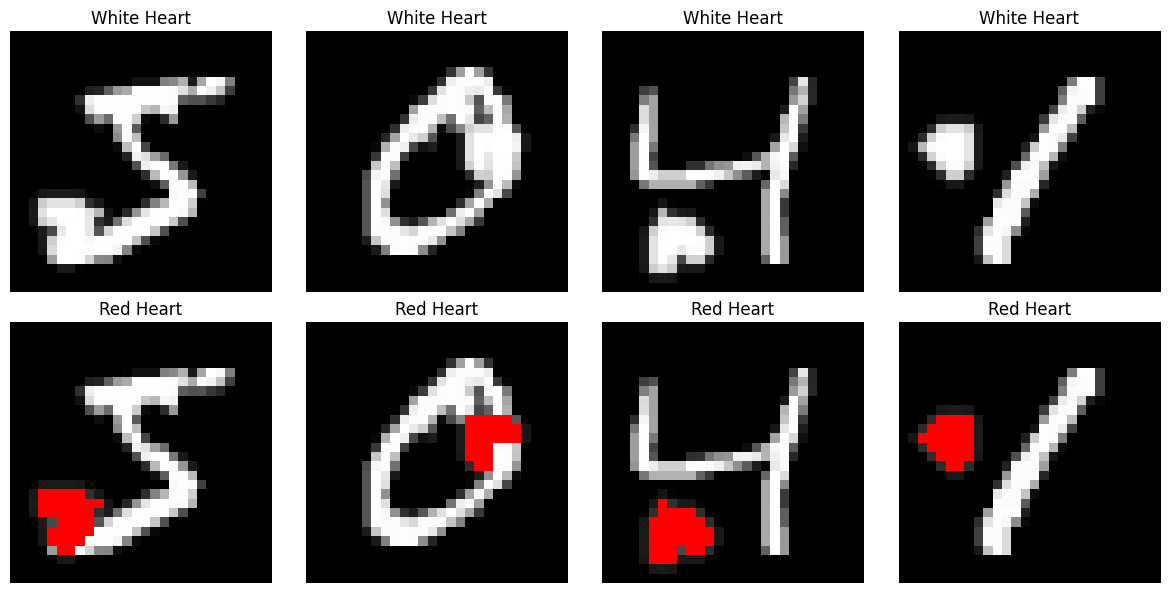

time: 1.22 s (started: 2025-03-15 14:21:15 +01:00)


In [14]:
from skimage.draw import polygon
from scipy.ndimage import gaussian_filter

def add_random_heart(image, mask):
    """
    Add a randomly rotated white heart with slightly softened edges to the image and update the mask
    """
    img = image.copy()
    msk = mask.copy()
    
    # Ensure correct dimensionality
    img2d = img[0] if (img.ndim == 3 and img.shape[0] == 1) else img
    H, W = img2d.shape

    heart_size = random.randint(5, 10)
    t = np.linspace(0, 2 * np.pi, 100)
    
    # Create a heart shape using a parametric equation
    x = heart_size * 16 * np.sin(t)**3
    y = -heart_size * (13 * np.cos(t) - 5 * np.cos(2*t) - 2 * np.cos(3*t) - np.cos(4*t))
    
    # Normalize and center the heart
    x = (x - x.min()) / (x.max() - x.min()) * (heart_size * 1.1)
    y = (y - y.min()) / (y.max() - y.min()) * (heart_size * 1.1)
    x, y = x - x.mean(), y - y.mean()
    pts = np.vstack((x, y)).T
    
    # Apply a random rotation
    angle = random.uniform(0, 360)
    rad = np.deg2rad(angle)
    R = np.array([[np.cos(rad), -np.sin(rad)], [np.sin(rad), np.cos(rad)]])
    pts_rot = pts.dot(R.T)
    
    # Shift the heart to a random valid position in the image
    min_xy = pts_rot.min(axis=0)
    box_wh = np.ceil(pts_rot.max(axis=0) - min_xy).astype(int)
    offset_x = random.randint(0, W - box_wh[0] - 1) if (W - box_wh[0] - 1) > 0 else 0
    offset_y = random.randint(0, H - box_wh[1] - 1) if (H - box_wh[1] - 1) > 0 else 0
    pts_final = pts_rot - min_xy + np.array([offset_x, offset_y])
    
    # Create a binary heart mask using polygon filling
    heart_binary = np.zeros((H, W), dtype=float)
    rr, cc = polygon(pts_final[:, 1], pts_final[:, 0], shape=(H, W))
    heart_binary[rr, cc] = 1.0

    # Apply a slight Gaussian blur to soften the heart's edge
    sigma = 0.5
    heart_blurred = gaussian_filter(heart_binary, sigma=sigma)
    
    # Blend the heart into the original image (the heart is white = 1.0)
    img2d = (1 - heart_blurred) * img2d + heart_blurred * 1.0
    
    # Update the segmentation mask with the original, sharp heart polygon
    msk[rr, cc] = 2

    # Restore the channel dimension if needed
    if img.ndim == 3 and img.shape[0] == 1:
        img = np.expand_dims(img2d, axis=0)
    else:
        img = img2d
        
    return img, msk

# Helper function just for visualizing the changes to the original image
def overlay_red(image, mask):
    """
    Convert a grayscale image into an RGB image and overlay the heart region (mask==2) in red
    """
    # Convert grayscale to RGB
    if image.ndim == 2:
        rgb = np.stack([image, image, image], axis=-1)
    elif image.ndim == 3 and image.shape[0] == 1:
        rgb = np.stack([image[0]] * 3, axis=-1)
    else:
        rgb = image.copy()
    
    # Replace the heart region with red (assuming image values are normalized to [0, 1])
    red_color = np.array([1.0, 0.0, 0.0])
    rgb[mask == 2] = red_color
    return rgb

def augment_dataset(x, y, subset_size):
    """
    Select a subset of examples, apply heart augmentation, and return the augmented images and masks
    """
    # Convert to NumPy arrays if necessary
    try:
        x_np, y_np = x.cpu().numpy(), y.cpu().numpy()
    except AttributeError:
        x_np, y_np = x, y
    
    x_sub, y_sub = x_np[:subset_size], y_np[:subset_size]
    x_aug, y_aug = zip(*[add_random_heart(img, msk) for img, msk in zip(x_sub, y_sub)])
    return np.array(x_aug), np.array(y_aug)

# Augment training set with a subset of 5000 examples
subset_size = 5000
x_train_hearts, y_train_hearts = augment_dataset(x_train, y_train_digits, subset_size)

# Augment test set with a subset of 1000 examples
subset_size_test = 1000
x_test_hearts, y_test_hearts = augment_dataset(x_test, y_test_digits, subset_size_test)

# Create images with red heart overlay
images_with_red_heart = [overlay_red(img, msk) for img, msk in zip(x_train_hearts, y_train_hearts)]

# Plot: First row shows images with the white heart;
# Second row shows images with the red heart overlay
plt.figure(figsize=(12, 6))
for i in range(4):  # Fixed to visualize 4 examples
    # First row: Image with white heart
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_train_hearts[i].squeeze(), cmap='gray')
    plt.title("White Heart")
    plt.axis("off")
    
    # Second row: Image with heart replaced by red
    plt.subplot(2, 4, 4 + i + 1)
    plt.imshow(images_with_red_heart[i])
    plt.title("Red Heart")
    plt.axis("off")

plt.tight_layout()
plt.show()

##### Fine-Tuning for 3 Classes
We now fine-tune the segmentation model for three classes: background, digit, and heart, as opposed to 2 in phase 1. It starts by loading pretrained weights from Phase 1, skipping the final layer due to the new class configuration. This process helps the model adapt to the new task of segmenting hearts, digits, and background.

In [15]:
model_phase2 = SegmentationModel(num_classes=3).to(device)

# Load pretrained weights from Phase 1 (skip the mismatched final layer by using strict=False)
pretrained_dict = torch.load('pretrained_model_phase1.pth', map_location=device)
model_dict = model_phase2.state_dict()

# Filter out unnecessary keys (the final layer might not match)
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'out_conv' not in k}
model_dict.update(pretrained_dict)
model_phase2.load_state_dict(model_dict)

optimizer_phase2 = optim.Adam(model_phase2.parameters(), lr=0.001)
criterion_seg = nn.CrossEntropyLoss()

print("Training Phase 2: Fine-tuning segmentation model with hearts (3 classes)...")
num_epochs_phase2 = 5

# Create DataLoader for phase 2 training
seg_hearts_train_ds = TensorDataset(torch.tensor(x_train_hearts).float(), torch.tensor(y_train_hearts).long())
seg_hearts_train_loader = DataLoader(seg_hearts_train_ds, batch_size=128, shuffle=True)

for epoch in range(num_epochs_phase2):
    model_phase2.train()
    running_loss = 0.0
    for imgs, masks in seg_hearts_train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer_phase2.zero_grad()
        outputs = model_phase2(imgs)
        loss = criterion_seg(outputs, masks)
        loss.backward()
        optimizer_phase2.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(seg_hearts_train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs_phase2}] - Loss: {epoch_loss:.4f}")

Training Phase 2: Fine-tuning segmentation model with hearts (3 classes)...
Epoch [1/5] - Loss: 0.3606
Epoch [2/5] - Loss: 0.1289
Epoch [3/5] - Loss: 0.1074
Epoch [4/5] - Loss: 0.0954
Epoch [5/5] - Loss: 0.0850
time: 1.14 s (started: 2025-03-15 14:21:16 +01:00)


We now compare the performance of a segmentation model trained with transfer learning (fine-tuned from Phase 1) against one trained from scratch on the same 3-class segmentation task. We initialize both models then train them.

Training from scratch for comparison...
Epoch [1/5] Transfer Loss: 0.0792, Scratch Loss: 0.5446
Epoch [2/5] Transfer Loss: 0.0774, Scratch Loss: 0.2381
Epoch [3/5] Transfer Loss: 0.0735, Scratch Loss: 0.1771
Epoch [4/5] Transfer Loss: 0.0705, Scratch Loss: 0.1553
Epoch [5/5] Transfer Loss: 0.0692, Scratch Loss: 0.1377


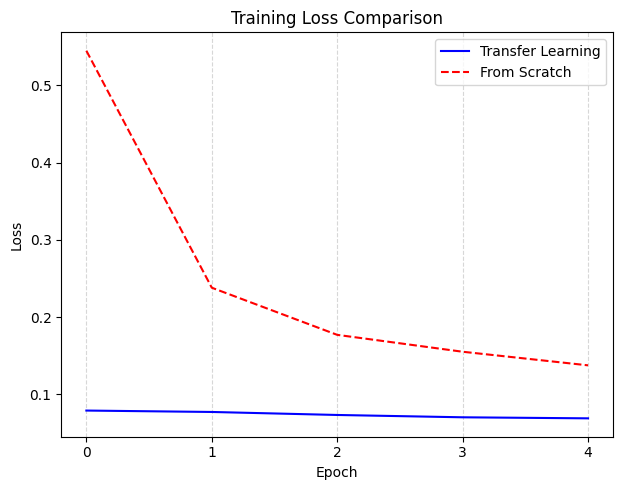

time: 1.93 s (started: 2025-03-15 14:21:17 +01:00)


In [16]:
# For comparison, train a new segmentation model from scratch on the 3-class problem
model_scratch = SegmentationModel(num_classes=3).to(device)
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

num_epochs_scratch = 5
loss_history_transfer = []
loss_history_scratch = []

# DataLoader for scratch training (reuse the hearts dataset)
seg_hearts_train_loader = DataLoader(seg_hearts_train_ds, batch_size=128, shuffle=True)

print("Training from scratch for comparison...")
for epoch in range(num_epochs_scratch):
    # Fine-tuning transfer learning model
    model_phase2.train()
    running_loss_phase2 = 0.0
    for imgs, masks in seg_hearts_train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer_phase2.zero_grad()
        outputs = model_phase2(imgs)
        loss = criterion_seg(outputs, masks)
        loss.backward()
        optimizer_phase2.step()
        running_loss_phase2 += loss.item() * imgs.size(0)
    epoch_loss_phase2 = running_loss_phase2 / len(seg_hearts_train_loader.dataset)
    loss_history_transfer.append(epoch_loss_phase2)

    # Model trained from scratch
    model_scratch.train()
    running_loss_scratch = 0.0
    for imgs, masks in seg_hearts_train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer_scratch.zero_grad()
        outputs = model_scratch(imgs)
        loss = criterion_seg(outputs, masks)
        loss.backward()
        optimizer_scratch.step()
        running_loss_scratch += loss.item() * imgs.size(0)
    epoch_loss_scratch = running_loss_scratch / len(seg_hearts_train_loader.dataset)
    loss_history_scratch.append(epoch_loss_scratch)

    print(f"Epoch [{epoch+1}/{num_epochs_scratch}] Transfer Loss: {epoch_loss_phase2:.4f}, Scratch Loss: {epoch_loss_scratch:.4f}")

# Plot the training loss curves for comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history_transfer, 'b-', label='Transfer Learning')
plt.plot(loss_history_scratch, 'r--', label='From Scratch')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Adding grid to the plot with dashed line style for the x-axis
ax = plt.gca()  # Get the current axis
ax.grid(axis='x', linestyle='--', alpha=0.5)

# Set x-ticks to integer values
ax.set_xticks(range(num_epochs_scratch))  # Make sure the x-ticks are integers

plt.legend()

plt.tight_layout()
plt.show()

##### Visualizing the results

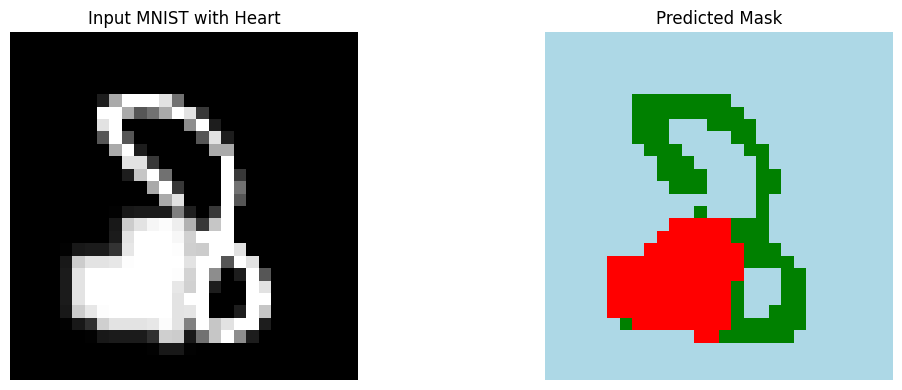

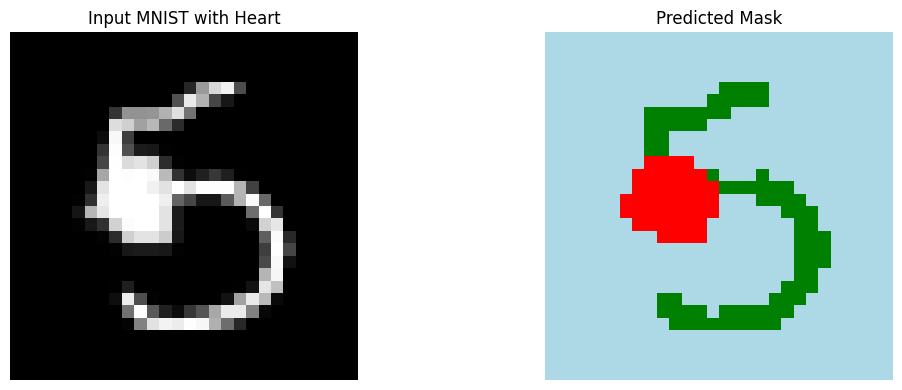

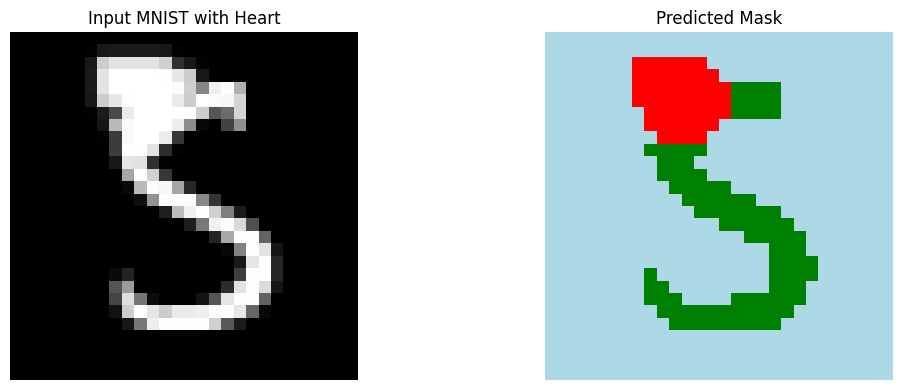

time: 247 ms (started: 2025-03-15 14:21:19 +01:00)


In [17]:
def visualize_sample(idx):
    """
    Visualize the original image and predicted segmentation mask (without the ground truth mask).
    """
    sample_img = x_test_hearts[idx]  # shape: [1, 28, 28]
    # Remove the ground truth mask, since you no longer need it
    # gt_mask = y_test_hearts[idx]  # This line is no longer needed
    
    model_phase2.eval()
    with torch.no_grad():
        inp = torch.tensor(sample_img).unsqueeze(0).float().to(device)  
        output = model_phase2(inp)  # output shape: [1, 3, 28, 28]
        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
    
    # Create a 1-row, 2-column layout for the subplots (no ground truth mask)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
    
    # Top row: "Input MNIST with Heart"
    ax[0].imshow(sample_img.squeeze(), cmap='gray')
    ax[0].set_title("Input MNIST with Heart")
    ax[0].axis('off')
    
    # Define a custom colormap for segmentation masks
    cmap_seg = ListedColormap(['lightblue', 'green', 'red'])
    
    # Top row: "Predicted Mask"
    ax[1].imshow(pred_mask, cmap=cmap_seg, vmin=0, vmax=2)
    ax[1].set_title("Predicted Mask")
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize a few random segmentation examples
num_visualizations = 3
for i in range(num_visualizations):
    idx = random.randint(0, len(x_test_hearts)-1)
    visualize_sample(idx)


## Part 3: Image Denoising with Autoencoders

In this section we build a convolutional autoencoder to perform image denoising.

<img src="img/AE_denoise.png" alt="Autoencorder" width="800"/>

The autoencoder compresses the image into a latent space and then reconstructs the image from this representation.

We will add Gaussian noise to the images and train the autoencoder to recover the clean images.

In [18]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Decoder
        self.dec1 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Encoder
        x = self.enc1(x)
        x = self.enc2(x)
        
        # Decoder
        x = self.dec1(x)
        x = self.dec2(x)
        x = self.dec3(x)
        
        return x

autoencoder = Autoencoder().to(device)
print(autoencoder)

Autoencoder(
  (enc1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dec1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
  )
  (dec2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
  )
  (dec3): Sequential(
    (0): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
  )
)
time: 2.13 ms (started: 2025-03-15 14:21:19 +01:00)


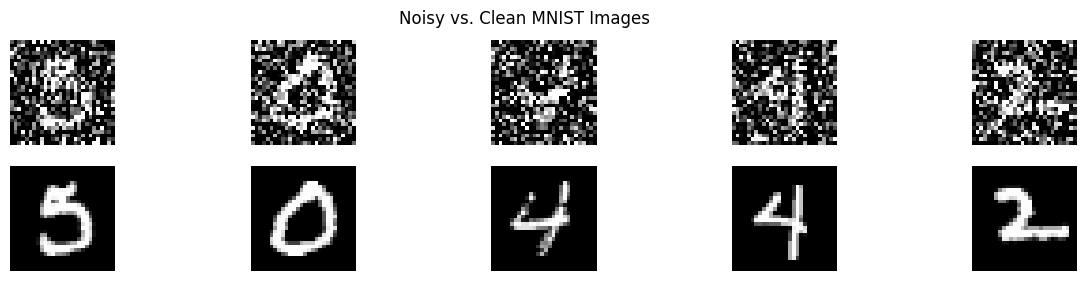

time: 1.51 s (started: 2025-03-15 14:21:19 +01:00)


In [19]:
# Add noise to images
noise_factor = 0.6
x_train_noisy = x_train + noise_factor * torch.randn_like(x_train)
x_test_noisy  = x_test + noise_factor * torch.randn_like(x_test)

# Clip the values to be within [0,1]
x_train_noisy = torch.clamp(x_train_noisy, 0., 1.)
x_test_noisy  = torch.clamp(x_test_noisy, 0., 1.)

# Randomly select 'n' images from the dataset
n = 5
random_indices = torch.randperm(x_test.size(0))[:n]

# Visualize some examples of noisy vs. clean images
plt.figure(figsize=(15, 3))

# Plot noisy images first
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[random_indices[i]].squeeze(), cmap='gray')
    plt.axis('off')

# Plot clean images second
for i in range(n):
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(x_test[random_indices[i]].squeeze(), cmap='gray')
    plt.axis('off')

plt.suptitle('Noisy vs. Clean MNIST Images')
plt.show()


##### Training the autoencoder

In [20]:
print("Training the autoencoder for denoising...")
num_epochs_ae = 5
ae_loss_history = []
criterion_ae = nn.BCELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=0.001)

# Create DataLoader for the autoencoder (input: x_train_noisy, target: x_train)
from torch.utils.data import TensorDataset, DataLoader
ae_train_ds = TensorDataset(x_train_noisy, x_train)
ae_train_loader = DataLoader(ae_train_ds, batch_size=128, shuffle=True)

for epoch in range(num_epochs_ae):
    autoencoder.train()
    running_loss = 0.0
    for noisy_imgs, clean_imgs in ae_train_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
        optimizer_ae.zero_grad()
        outputs = autoencoder(noisy_imgs)
        loss = criterion_ae(outputs, clean_imgs)
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item() * noisy_imgs.size(0)
    epoch_loss = running_loss / len(ae_train_loader.dataset)
    ae_loss_history.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs_ae}] - Loss: {epoch_loss:.4f}")

Training the autoencoder for denoising...
Epoch [1/5] - Loss: 0.1804
Epoch [2/5] - Loss: 0.1283
Epoch [3/5] - Loss: 0.1219
Epoch [4/5] - Loss: 0.1187
Epoch [5/5] - Loss: 0.1166
time: 13.3 s (started: 2025-03-15 14:21:21 +01:00)


##### Visualizing the results

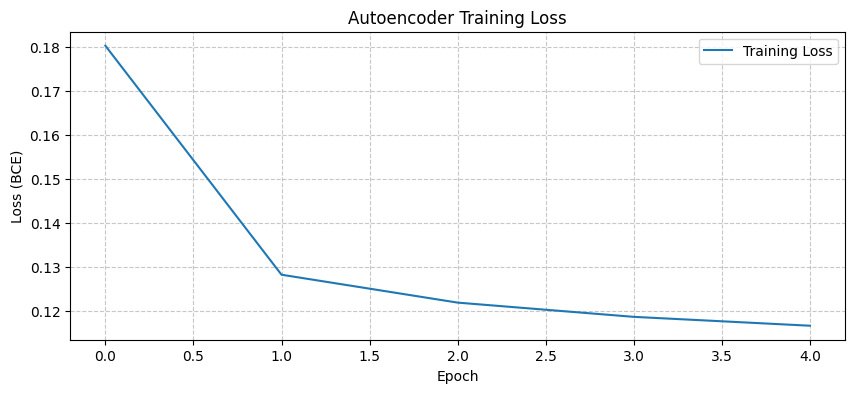

time: 99.4 ms (started: 2025-03-15 14:21:34 +01:00)


In [21]:
# Plot autoencoder training loss
plt.figure(figsize=(10, 4))
plt.plot(ae_loss_history, label='Training Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (BCE)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

##### Evaluating model performance

This code snippet evaluates the performance of the trained autoencoder on the test set. Here we also use the Mean Squared Error (MSE) to measure the average squared difference between the predicted (denoised) and actual (clean) values.

Mean Squared Error: 0.016864


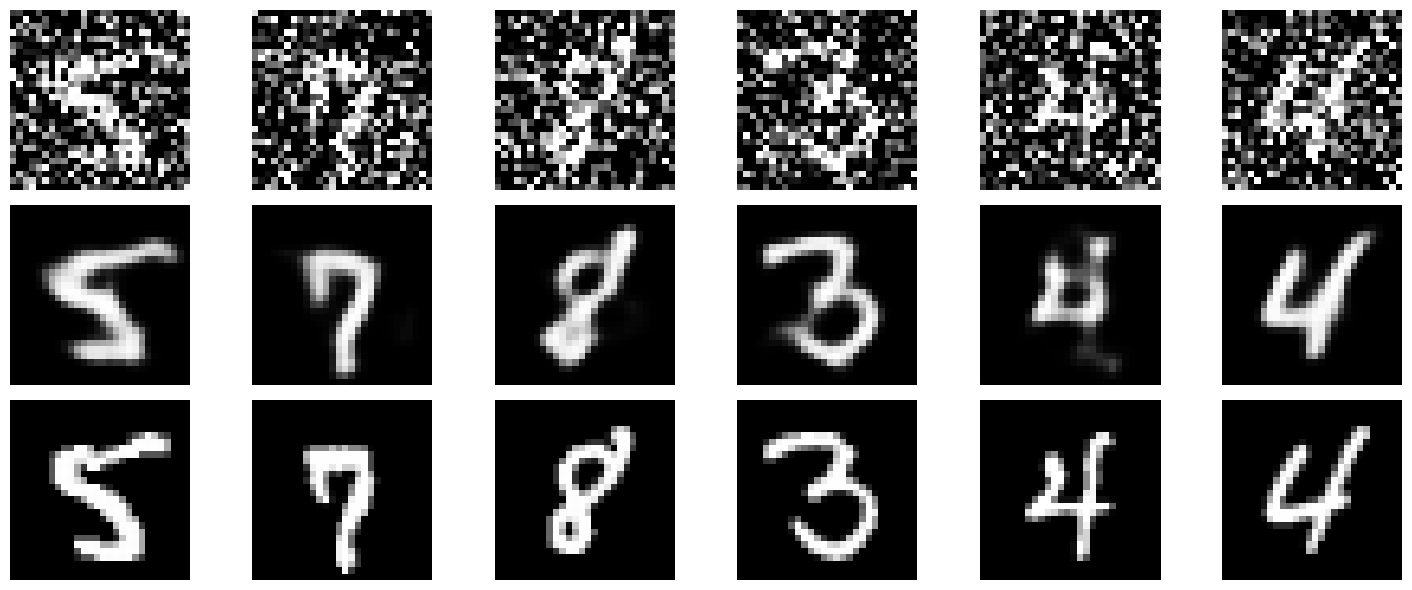

time: 221 ms (started: 2025-03-15 14:21:34 +01:00)


In [22]:
# Evaluate the autoencoder on the test set
autoencoder.eval()
with torch.no_grad():
    decoded_imgs = autoencoder(x_test_noisy.to(device)).cpu()

# Calculate Mean Squared Error between clean and denoised images
mse = np.mean((x_test.cpu().numpy() - decoded_imgs.numpy()) ** 2)
print(f"Mean Squared Error: {mse:.6f}")

# Choose 'n' random examples from the test set
n = 6
random_indices = np.random.choice(len(x_test), n, replace=False)

plt.figure(figsize=(15, 6))
for i, idx in enumerate(random_indices):
    # Noisy input
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[idx].squeeze(), cmap='gray')
    if i == 0:
        plt.ylabel('Noisy Input', fontsize=14)
    plt.axis('off')
    
    # Denoised output
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(decoded_imgs[idx].squeeze(), cmap='gray')
    if i == 0:
        plt.ylabel('Denoised Output', fontsize=14)
    plt.axis('off')
    
    # Original image
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    if i == 0:
        plt.ylabel('Original Image', fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.show()

In the cell below, we explore the latent space of an autoencoder by defining an encoder that extracts the latent representation of input data. The encoder is constructed using two pooling layers from a pre-trained autoencoder.

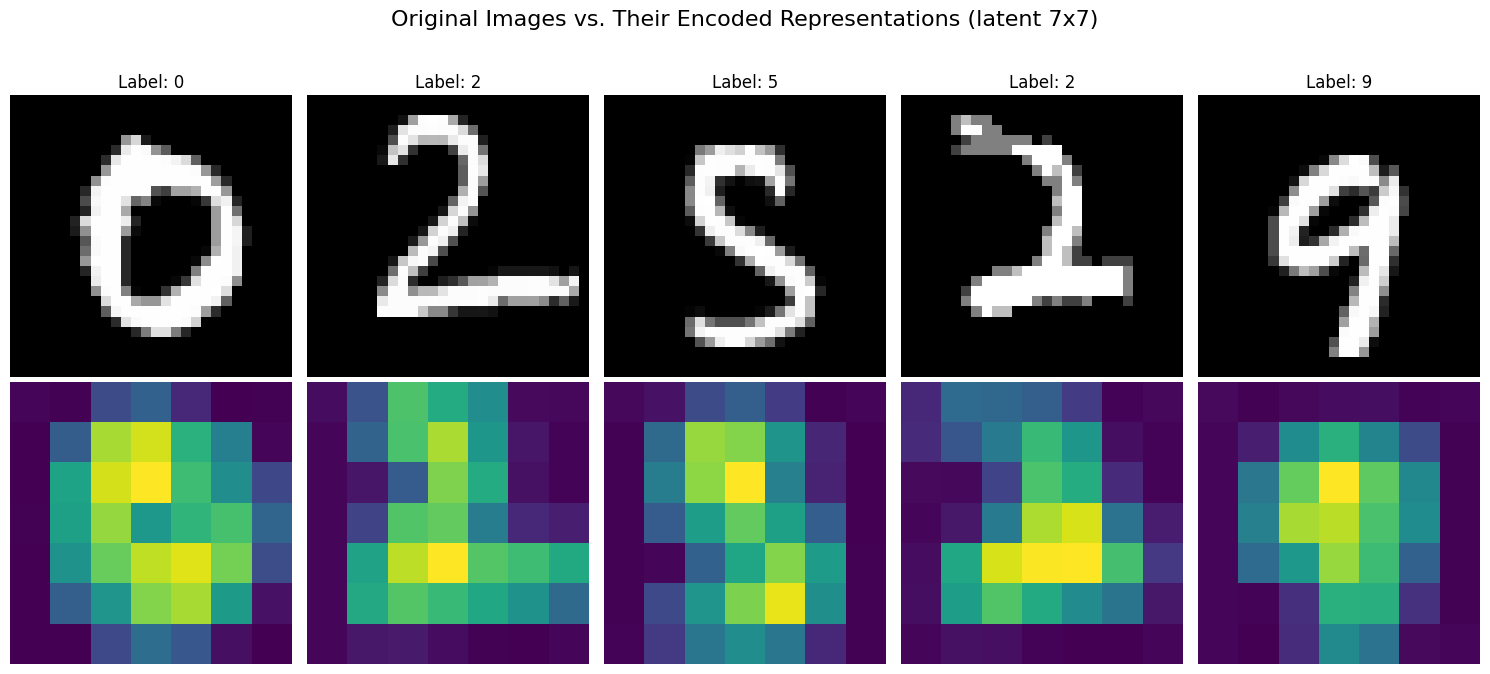

time: 167 ms (started: 2025-03-15 14:21:35 +01:00)


In [23]:
# Exploring the latent space of the autoencoder
# We define an encoder that returns the latent representation (after two pooling layers)
class Encoder(nn.Module):
    def __init__(self, autoencoder):
        super(Encoder, self).__init__()
        self.enc1 = autoencoder.enc1  # Use enc1 directly
        self.enc2 = autoencoder.enc2  # Use enc2 directly
    
    def forward(self, x):
        x = self.enc1(x)  # Applies Conv2d, ReLU, and MaxPool2d
        x = self.enc2(x)  # Applies Conv2d, ReLU, and MaxPool2d
        return x

encoder = Encoder(autoencoder).to(device)

# Randomly select 10 indices from the test dataset
random_indices = np.random.choice(len(x_test), 10, replace=False)

# Get encoded representations for the randomly selected test images
autoencoder.eval()
with torch.no_grad():
    encoded_imgs = encoder(x_test[random_indices].to(device)).cpu().numpy()

plt.figure(figsize=(15, 7))
for i in range(5):
    # Original image
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[random_indices[i]].squeeze(), cmap='gray')
    plt.title(f"Label: {y_test[random_indices[i]].item()}")
    plt.axis('off')
    
    # Encoded representation: average over channels
    ax = plt.subplot(2, 5, i + 6)
    encoded_img = encoded_imgs[i].mean(axis=0)
    plt.imshow(encoded_img, cmap='viridis')
    plt.axis('off')

plt.suptitle('Original Images vs. Their Encoded Representations (latent 7x7)', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

##### Comparison of different noise levels

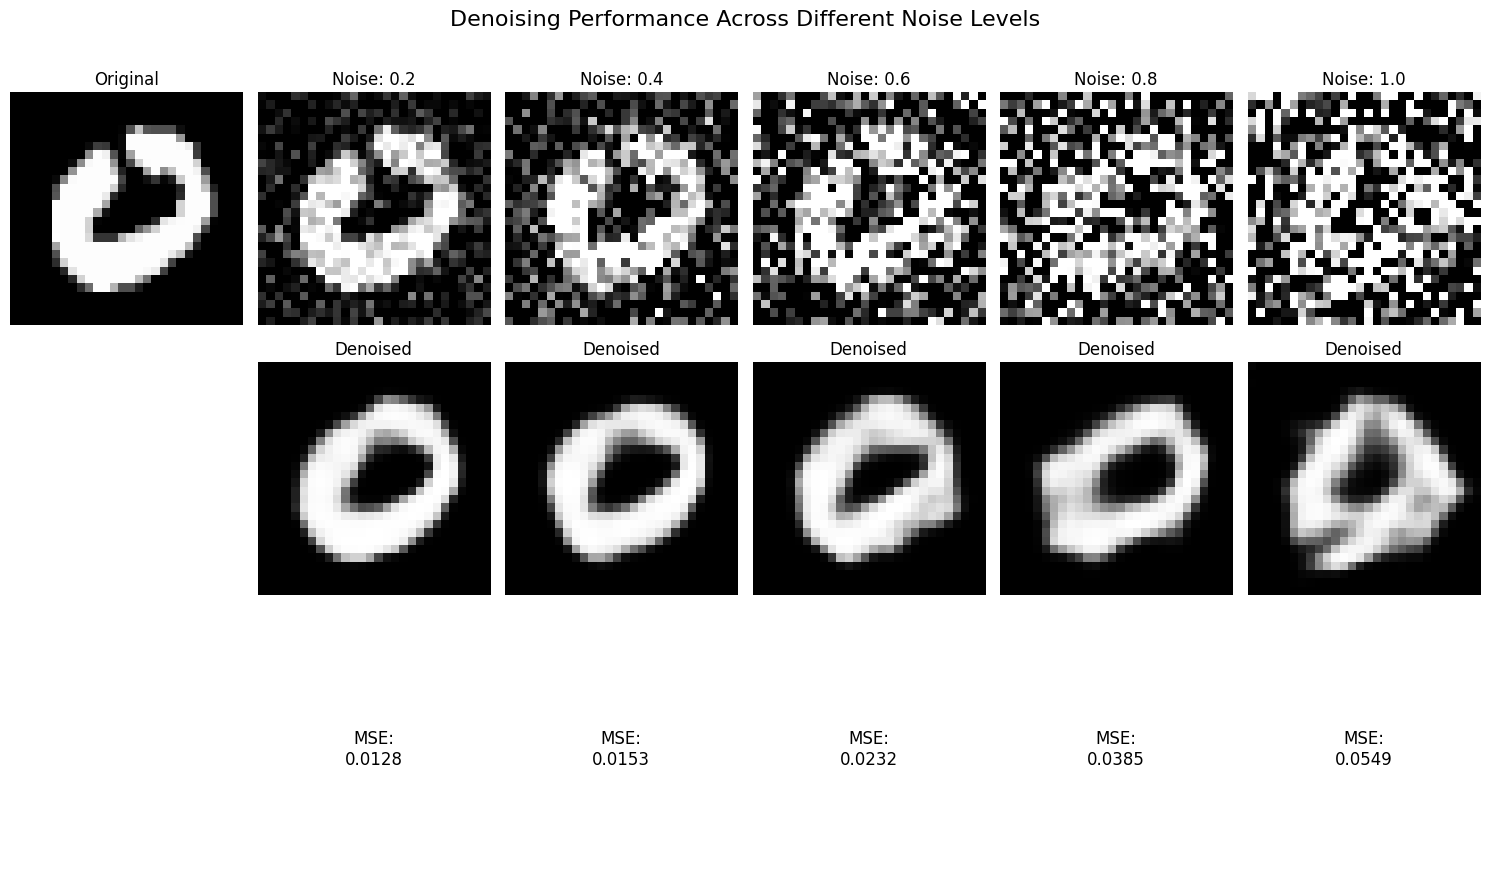

time: 342 ms (started: 2025-03-15 14:21:35 +01:00)


In [24]:
def add_noise(images, noise_factor):
    """Add gaussian noise to images and clip to [0,1]."""
    noisy = images + noise_factor * torch.randn_like(images)
    return torch.clamp(noisy, 0., 1.)

noise_levels = [0.2, 0.4, 0.6, 0.8, 1.0]
sample_idx = 25  # sample image index

plt.figure(figsize=(15, 9))

# Display the original image
plt.subplot(3, len(noise_levels) + 1, 1)
plt.imshow(x_test[sample_idx].squeeze(), cmap='gray')
plt.title('Original')
plt.axis('off')

for i, noise in enumerate(noise_levels):
    noisy_sample = add_noise(x_test[sample_idx:sample_idx+1], noise)
    
    # Denoise the sample
    autoencoder.eval()
    with torch.no_grad():
        denoised_sample = autoencoder(noisy_sample.to(device)).cpu()
    
    # Display noisy image
    plt.subplot(3, len(noise_levels) + 1, i + 2)
    plt.imshow(noisy_sample[0].squeeze(), cmap='gray')
    plt.title(f'Noise: {noise}')
    plt.axis('off')
    
    # Display denoised image
    plt.subplot(3, len(noise_levels) + 1, i + len(noise_levels) + 3)
    plt.imshow(denoised_sample[0].squeeze(), cmap='gray')
    plt.title('Denoised')
    plt.axis('off')
    
    # Compute and display MSE
    mse_val = np.mean((x_test[sample_idx].cpu().numpy() - denoised_sample[0].cpu().numpy()) ** 2)
    plt.subplot(3, len(noise_levels) + 1, i + 2*len(noise_levels) + 4)
    plt.text(0.5, 0.5, f'MSE:\n{mse_val:.4f}', ha='center', va='center', fontsize=12)
    plt.axis('off')

plt.suptitle('Denoising Performance Across Different Noise Levels', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()